# Sample Analysis with Example Data

## Introduction

In this analysis, we look at the shift data of ice hockey players using sample data from an event export from the provider Kinexon to gain insights into players' game strategies and performance. 

By examining shift lengths, intensities and pauses between shifts, we can evaluate players' endurance and effectiveness throughout the game. The use of `utils.py` allows us to efficiently process and visualize data.

The aim of this notebook is to give potential users of the algorithm an insight into the type of analyses performed and the resulting findings.

## 1. Data Loading

First, we load the shift data with the `read_file` function. This function extracts the relevant information from the exported event data and prepares it for analysis.

In [44]:
# necessary to detect changes in py files
%load_ext autoreload
%autoreload 2

# Import the necessary functions for data loading
from algorithms.utils import read_file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# Define the file path and the event type
file_name = 'data/Events-Match_GAME_2-3_Phases.csv'
event_type = 'Shifts'

# Load the data with the read_file function from utils.py
df = read_file(file_name, event_type)

# Display the first lines of the DataFrame for checking
df.head()

,Timestamp (ms),Timestamp in local format,Player ID,Name,Event type,Duration (s),Distance,Distance (speed | Very low),Distance (speed | Low),Distance (speed | Medium),Distance (speed | High),Distance (speed | Very high),Distance (speed | Sprint),Distance (speed | 0 - 0 km/h),Metabolic Power (Ø),Speed (max.),Skating Load,Skating Intensity
0,1706640353000,01/30/2024;07:45:53.000 PM,704,D_5 D_5,Shift,37.201000,120,29.0,63.0,7.0,4.0,5.0,12.0,NaN,288.40,25.39,25.84,41.67
1,1706640353000,01/30/2024;07:45:53.000 PM,708,D_6 D_6,Shift,49.101002,161,35.0,36.0,42.0,32.0,15.0,0.0,NaN,278.96,22.17,30.52,37.30
2,1706640353000,01/30/2024;07:45:53.000 PM,710,FW_13 FW_13,Shift,35.151001,126,21.0,25.0,18.0,15.0,12.0,36.0,NaN,369.15,30.23,33.04,56.40
3,1706640353000,01/30/2024;07:45:53.000 PM,717,FW_2 FW_2,Shift,34.151001,164,16.0,6.0,15.0,52.0,27.0,48.0,NaN,421.47,31.55,24.10,42.34
4,1706640353000,01/30/2024;07:45:53.000 PM,714,FW_6 FW_6,Shift,35.351002,117,32.0,5.0,9.0,31.0,20.0,19.0,NaN,357.76,29.18,35.34,59.99


## 2. Shift Analysis

Now that we have gained an overview of the shift data, the next step is to go deeper into the analysis of shifts. 

This chapter focuses on the detailed examination of the shifts, starting with determining the optimal number of shifts per player (cf [2.1](#2_1)). Identifying the optimal number of shifts is a crucial step in effectively segmenting the data and gaining precise insights into game strategies.

The subsequent analysis of shift length, time between shifts and intensity of individual shifts using visualizations allows us to understand the stress and performance of players during the game (cf [2.2](#2_2)).

<a id="2_1"></a>
### 2.1 Optimal Number of Shifts

To analyze the shifts effectively, we first need to determine the optimal number of shifts. The `find_optimal_amount_of_shifts` function uses either a combination of the Elbow method and K-Means clustering to determine the ideal number of clusters for our shift data, or a simple method based on the number of players. The latter method usually works better, as we will see later (cf [2.2.2](#2_2_2)).

In [4]:
from algorithms.utils import find_optimal_amount_of_shifts

# Determine the optimum number of shifts
optimal_shifts, _ = find_optimal_amount_of_shifts(df, simple=True, verbose=False)
print(f"Optimale Anzahl von Shifts - simple: {optimal_shifts}")

optimal_shifts, _ = find_optimal_amount_of_shifts(df, simple=False, verbose=False)
print(f"Optimale Anzahl von Shifts - elbow: {optimal_shifts}")

Optimale Anzahl von Shifts - simple: 143
Optimale Anzahl von Shifts - elbow: 85


<a id="2_2"></a>
### 2.2 Shift Intensity

#### 2.2.1 Preparation of the Data Frame

Before we start the visualization, we need to make sure that the dataframe contains all the necessary information. This includes the `Player ID`, the `Timestamp (ms)` for each shift, the `Duration (s)` of the shifts and the corresponding `Skating Intensity`.

In addition, the goalkeepers should be removed, as they do not belong to any shift.

Finally, only one team is considered in order to keep the visualization clear.

In [48]:
# Check player names
print("Player names:\n", df["Name"].unique())
print("Number of players:\n", len(df["Name"].unique()))

Player names:
 ['D_5 D_5' 'D_6 D_6' 'FW_13 FW_13' 'FW_2 FW_2' 'FW_6 FW_6' 'FW_8 FW_8'
 'FW_9 FW_9' 'FW_7 FW_7' 'D_4 D_4' 'D_1 D_1' 'D_2 D_2' 'FW_4 FW_4'
 'D_3 D_3' 'FW_5 FW_5' 'FW_10 FW_10' 'FW_3 FW_3' 'FW_12 FW_12'
 'FW_11 FW_11' 'D_7 D_7']
Number of players:
 19


In [5]:
# Check for required columns
if not {"Timestamp (ms)", "Duration (s)", "Player ID", "Skating Intensity"}.issubset(df.columns):
    raise ValueError("The DataFrame does not contain the necessary columns for visualization.")
else:
    print("All required columns are present in the DataFrame.")
    
# Remove goalkeepers    
df = df[~df["Name"].str.contains("Goalkeeper")]

# Choose team
df_guest = df[df["Name"].str.contains("Guest")]
df_home = df[~df["Name"].str.contains("Guest")]


All required columns are present in the DataFrame.


In this analysis, we focus on the shift intensities of the **guest team**. Of course, the following visualizations can also be used for the home team.

<a id="2_2_2"></a>
#### 2.2.2 Visualization of the Shift Intensity

With the function `plot_shifts_with_intensity` we create a visualization that shows the shifts of all players together with the intensity of each individual shift. The `get_colour` function is used to color code the intensity of the shifts, which helps us to visually capture the physical load of the players.

This visualization helps us to identify patterns in player shifts and their impact on game intensity.

The last two plots can also be used to compare shift intensities between guest and home team in the first third. 

Shift Intensities, First Third


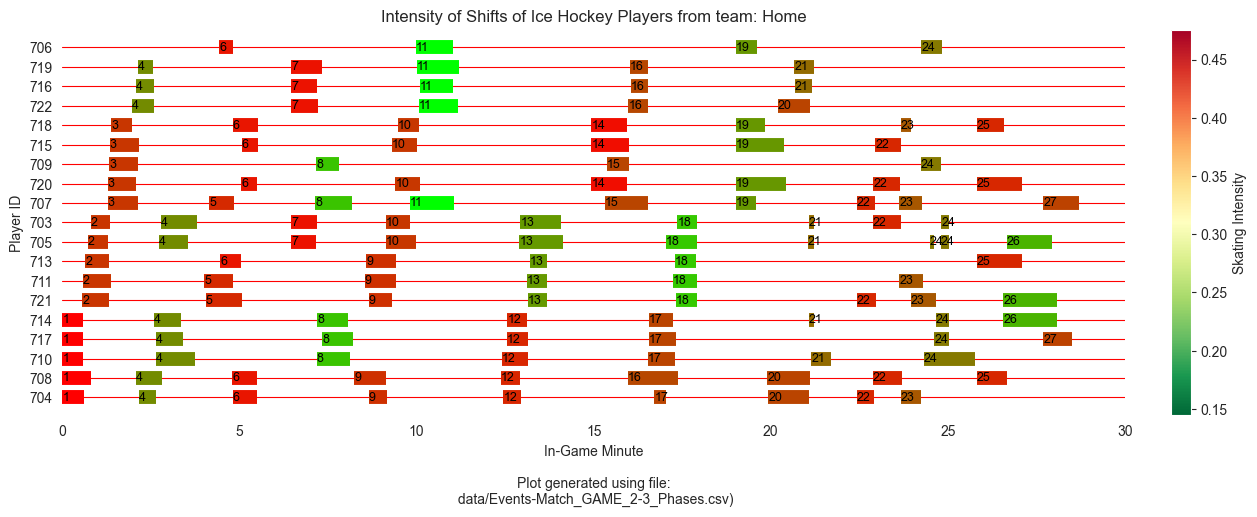

Shift Intensities, Second Third


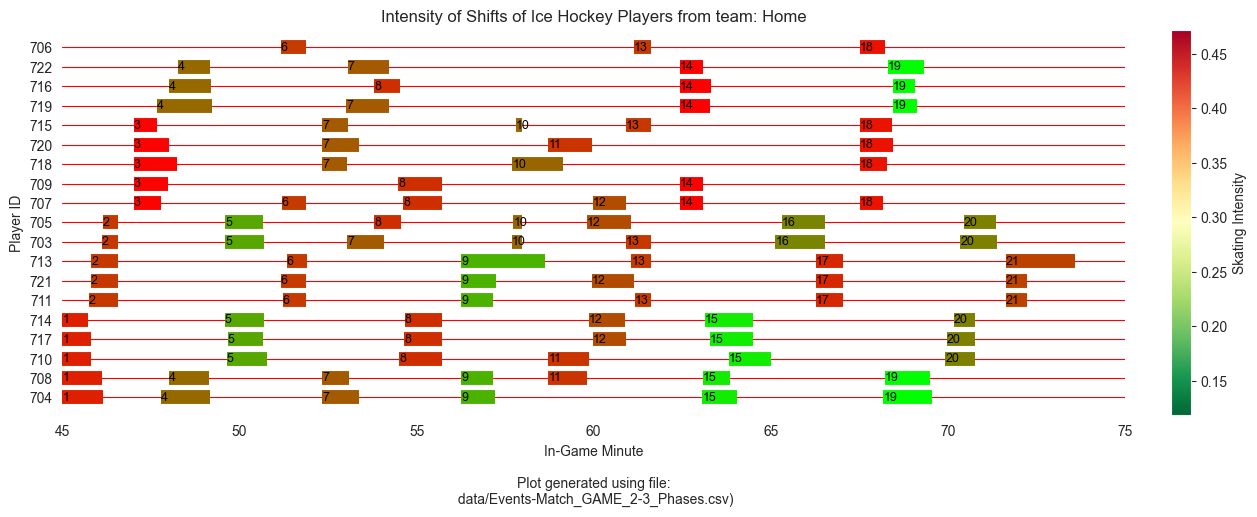

Shift Intensities, Third Third


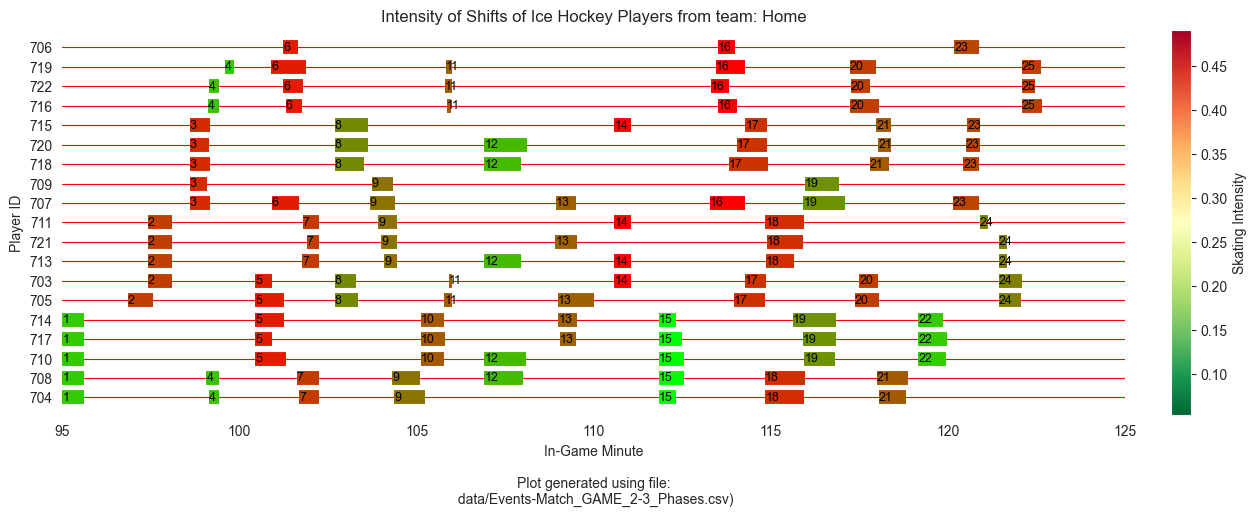

In [54]:
from algorithms.utils import generate_block_config, plot_shifts_with_intensity, BLOCK_CONFIG_NOF_SHIFTS_DESCRIPTOR, BLOCK_CONFIG_TEAM_NAME_DESCRIPTOR

# Generate the block configuration for the visualization
block_config = generate_block_config(
    naive=True,  # or False, depending on the analysis
    verbose=False,
    team_name="Home",
    file_name_raw_data=file_name,
    file_name_save_plot=None  # Optional
)

# For comparison, the shifts with the elbow method
print("Shift Intensities, First Third")
_ = plot_shifts_with_intensity(
    df, 
    block_config,
    time_window_start=0,  # Start time in playing minutes
    time_window_duration=30,  # Duration of the window to be visualized in minutes
    intensity_indicator="Skating Intensity"  # The exact column in your df
)

print("Shift Intensities, Second Third")
_ = plot_shifts_with_intensity(
    df, 
    block_config,
    time_window_start=45,  # Start time in playing minutes
    time_window_duration=30,  # Duration of the window to be visualized in minutes
    intensity_indicator="Skating Intensity"  # The exact column in your df
)

print("Shift Intensities, Third Third")
_ = plot_shifts_with_intensity(
    df, 
    block_config,
    time_window_start=95,  # Start time in playing minutes
    time_window_duration=30,  # Duration of the window to be visualized in minutes
    intensity_indicator="Skating Intensity"  # The exact column in your df
)

As can be seen in the two graphics, the "simple" method (upper graphic) for recognizing shifts delivers better results. While this method identifies the correct 5 players per shift with a few exceptions, the elbow method has more difficulties in identifying 'flying' shifts as shift changes (e.g. shift 1 in the lower graphic contains 9 players). This is due to the fact that the "elbow" method normally calculates a lower optimal number of shifts (cf [2.1](#2_1))

#### 2.2.3 Shift Intensity Score (SIS)

The intensity of each shift provides valuable insights into the effort, performance and stress of the players during their shift. To quantify this intensity and compare it between players, we calculate a **SIS** for each player using `add_sis_column`. This score indicates the intensity of a player's use compared to the average of all players.

To calculate the **SIS**, we first determine the average intensity of each player's bets. Then, we calculate the average intensity of all of a player's assignments. Next, we determine the average intensity of all the players' efforts. Finally, we divide the average intensity of a player by the total average intensity to get the **SIS**.

In [19]:
# find all players in Guest Team
print("Home Players:")
print(df[df["Name"].str.contains("TEST")]["Player ID"].unique())

print(55*"-")

# find all players in Home Team
print("Away Players:")
print(df[~df["Name"].str.contains("TEST")]["Player ID"].unique())

Home Players:
[438 443 448 447 456 449 444 439 451 453 450 445 454 441 455 452 457 446
 442]
-------------------------------------------------------
Away Players:
[470 471 478 479 480 483 482 481 468 469 486 484 485 488 487 489 472 473
 474 490]


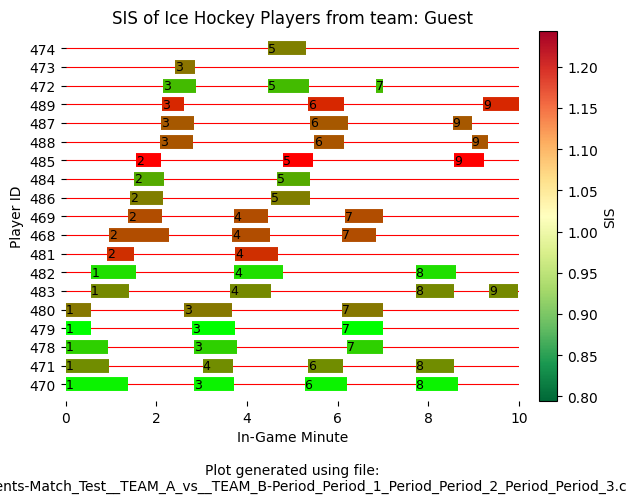

In [20]:
from algorithms.utils import add_sis_column, plot_SIS

# Select players by player ID (Guest Team)
players = [470, 471, 478, 479, 480, 462, 483, 482, 481, 468, 469, 486, 484, 485, 488, 487, 489, 472, 473, 474, 490]

# Calculation of the Shift Intensity Score (SIS) for each player
df_with_sis = add_sis_column(df, players)

# Optional: Display the first lines of the enriched DataFrame for verification
# print(df_with_sis.head())

# Plot SIS
plot_SIS(df_with_sis,
         0,
         10,
         team_name="Guest",
         file_name_raw_data=file_name
         )

The intensity of the shifts for the individual players can also be visualized at player level using the `plot_skating_intensity` function. The shifts per player are displayed over time.

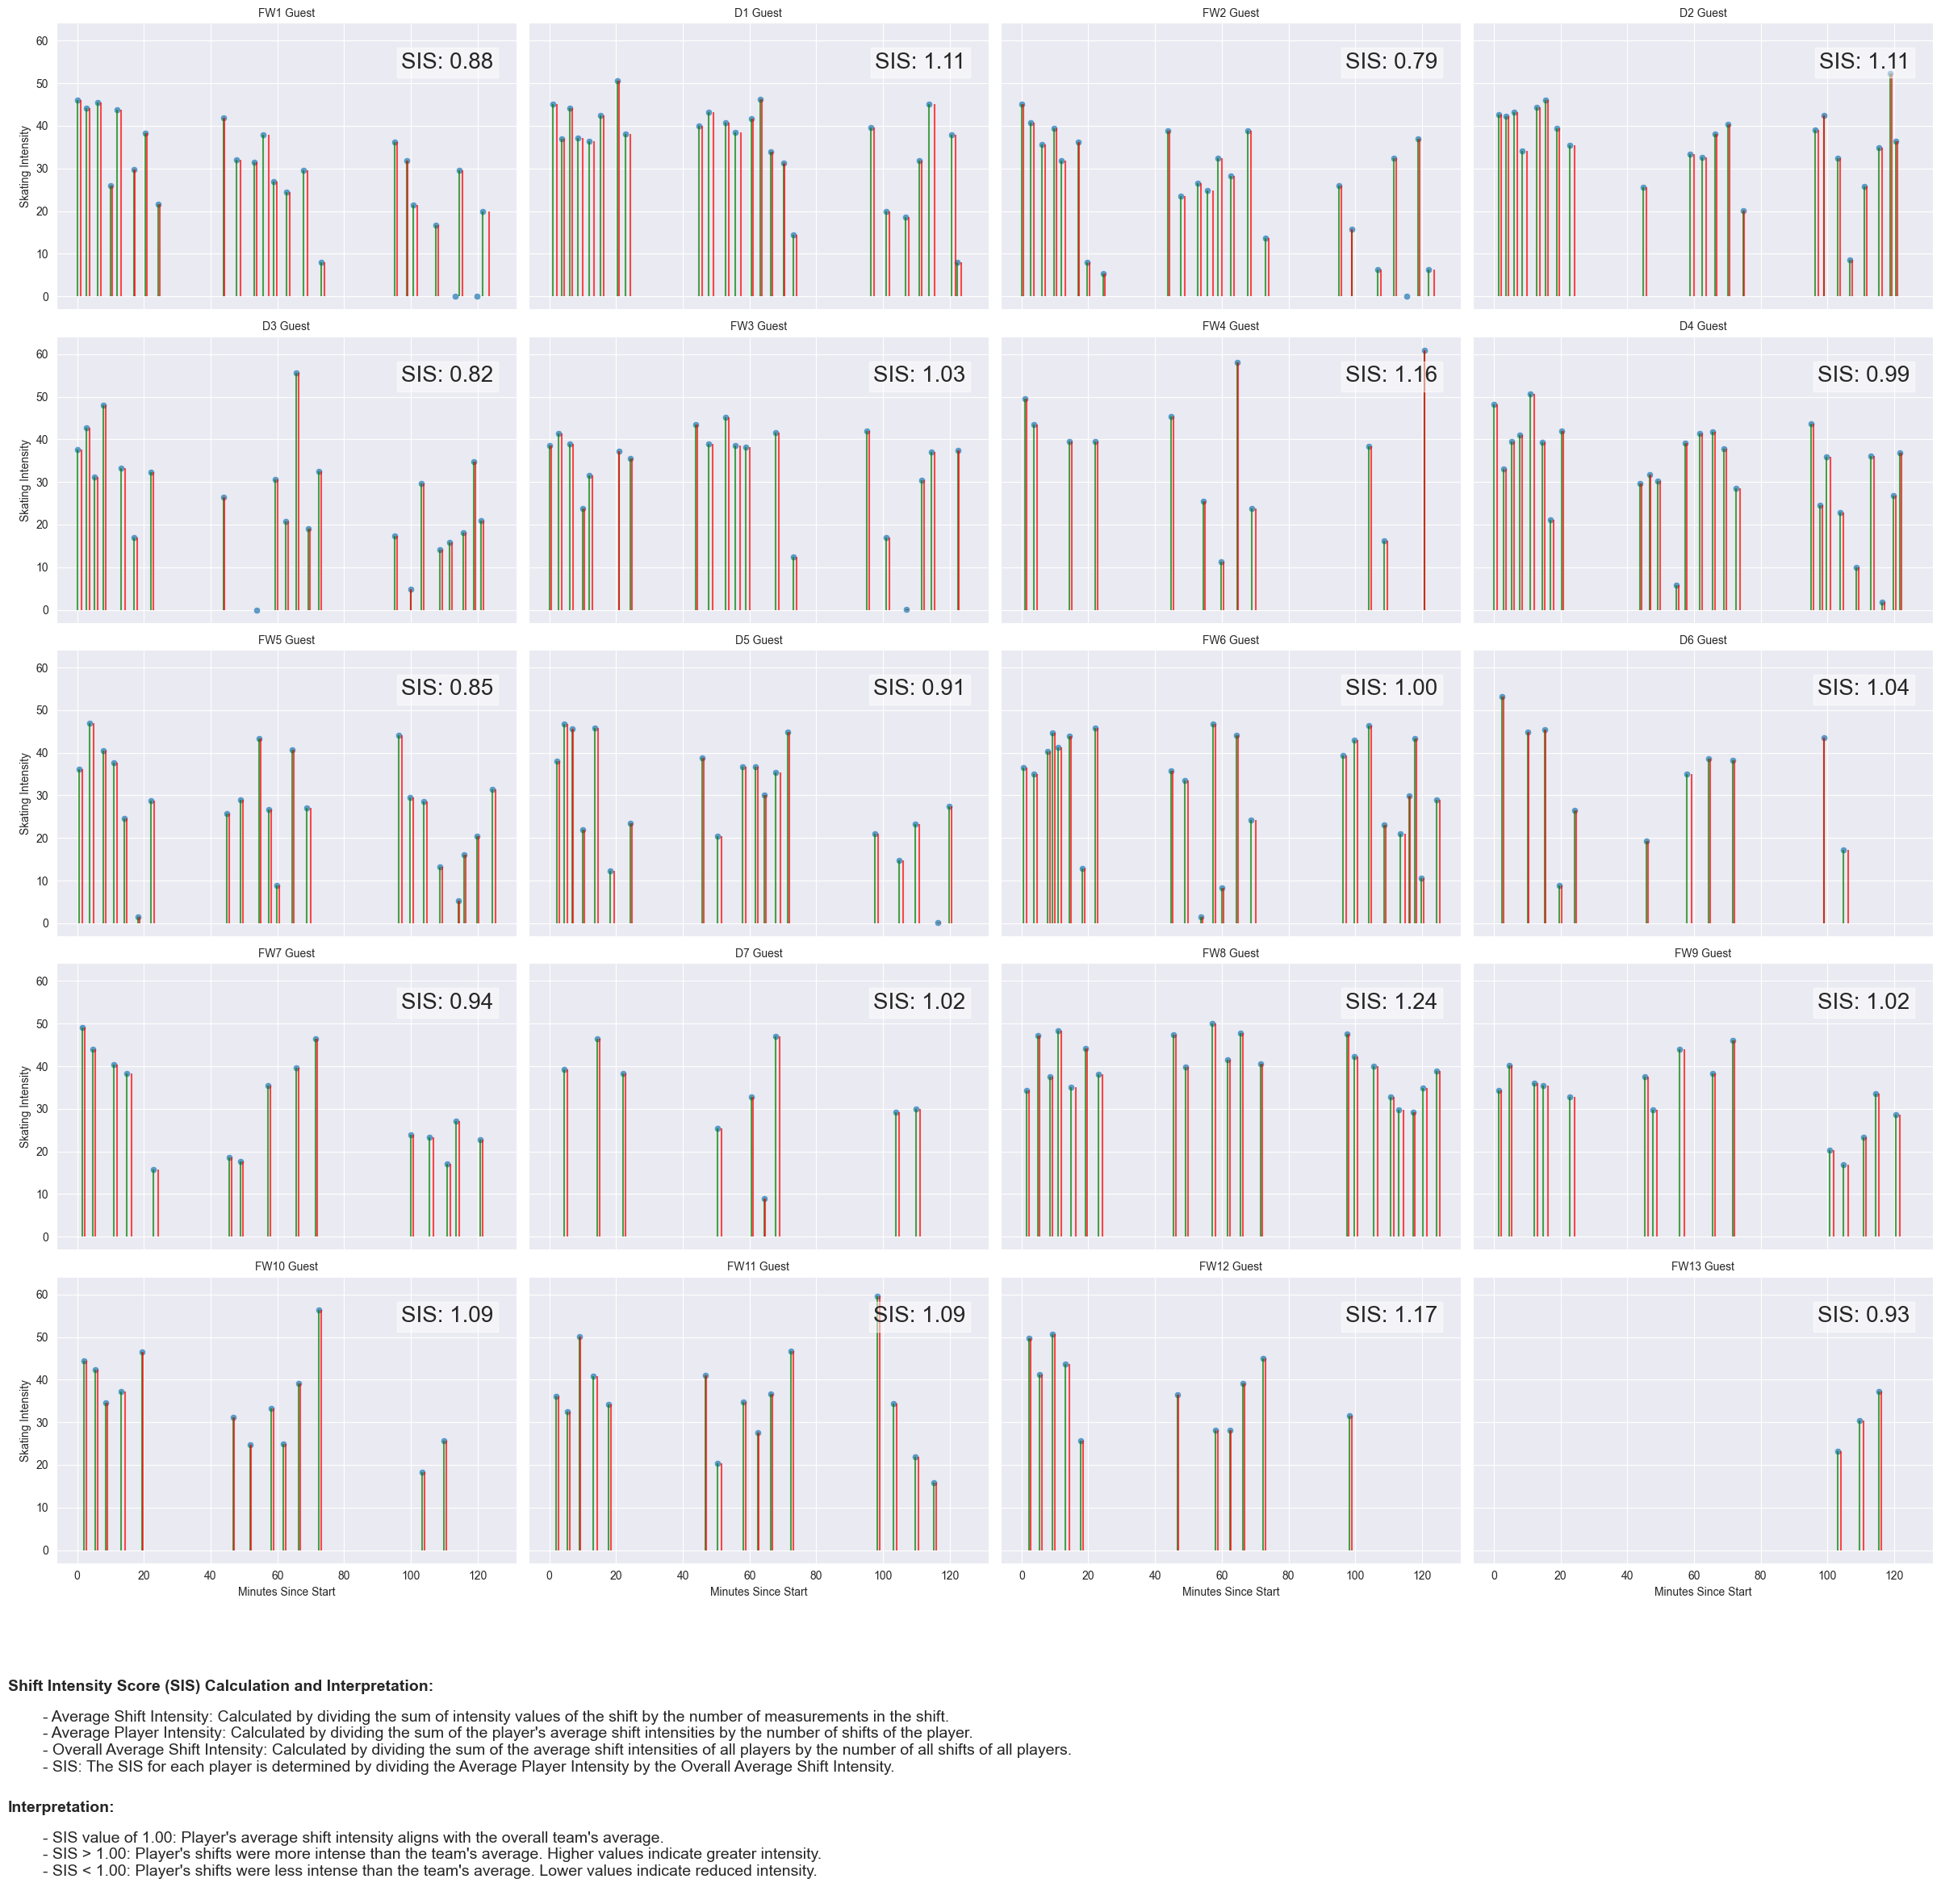

In [ ]:
from algorithms.utils import plot_skating_intensity

# Player selection 
players_guest = df_with_sis[df_with_sis['Name'].str.contains("Guest")]['Name'].unique().tolist()

plot_skating_intensity(df_with_sis, players_guest, 0, 130)


In [1]:
# DELETE THIS
import requests

url = "http://localhost:8082/school"
myobj = {
    "schoolName":"Royal College",
    "location":"Clobivilla",
    "principalName":"Mr Oak"
}
x = requests.post(url, json = myobj)
print(x.text)

{"timestamp":"2024-02-26T21:17:38.751+00:00","status":404,"error":"Not Found","path":"/school"}


## Conclusion and Outlook

The analysis of shift data provides valuable insights into the physical performance and strategic approach of players in ice hockey. By applying functions from `utils.py`, the data can be efficiently loaded, processed and visualized. Future studies could incorporate additional metrics and phases of play to make the analysis even more detailed.